 # Predict click-through rates on display ads 
Internet advertising revenues in the United States totaled almost $60 billion in 2015, a 20% increase over 2014. Revenue numbers for 2016, when available, are expected to continue this trend. In addition, display advertising represents one of the most popular uses of machine learning on the Internet.
  
CriteoLabs (http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/) has made data available to develop models for predicting ad click-through rate (CTR). In this demo, we will only be using the much smaller test.csv dataset, rather than the larger train.csv dataset for both training and cross validating the model. Our goal is to demonstrate the process of exploring the data and creating machine learning pipelines in Python, rather than attempting to achieve the best score for predictions. The smaller dataset will make it much easier for users to download and begin using the data quickly. The trade-off is that the quantity of data limits the ability to accurately train a model. Users can download the larger train.csv dataset themselves to develop a more accurate model of click-through rates.
  
The dataset used in this demo (test.csv) consists of a portion of Criteo's traffic over a period of a day. Each row corresponds to a display ad served by Criteo. The data sample includes positive (clicked) and negative (non-clicked) examples and is labeled with respect to whether the ad was clicked or not.
  
Here is a description of the data fields in the dataset. The data includes missing values.

    Label - Target variable that indicates if an ad was clicked (1) or not (0).
    I1-I13 - A total of 13 columns of integer features (mostly count features).
    C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 


In this demo, we will explore how to explore data and create a machine learning pipeline using Python and scikit-learn. In addition, we will demonstrate how the spark-sklearn package (https://spark-packages.org/package/databricks/spark-sklearn) can be used to train and evaluate multiple scikit-learn models in parallel. Specifically, spark-sklearn distributes the search for estimator parameters (GridSearchCV in scikit-learn) using Spark.

It combines the strengths of Spark and scikit-learn with no changes to users’ code. It re-implements some components of scikit-learn that benefit the most from distributed computing. Users will find a Spark-based cross-validator class that is fully compatible with scikit-learn’s cross-validation tools. By swapping out a single class import, users can distribute cross-validation for their existing scikit-learn workflows.

The spark-sklearn integration package for Spark combines the strengths of Spark and scikit-learn with no changes to user code. The spark-sklearn package re-implements components of scikit-learn that can be run in parallel in a distributed computing environment. For example, a Spark-based cross-validator class that is fully compatible with scikit-learn’s cross-validation tools is provided. The Spark-based cross-validator can simply be imported in to replace scikit-learn's GridSearchCV cross-validation tool. This enables cross-validation for existing scikit-learn workflows to be run in parallel.

## Upgrade pandas and sklearn packages to latest versions

In [1]:
# Upgrade pandas - need pandas 0.19.0 or greater
!pip install pandas --upgrade
# Upgrade scikit-learn
!pip install sklearn --upgrade

Requirement already up-to-date: pandas in /gpfs/global_fs01/sym_shared/YPProdSpark/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages
Requirement already up-to-date: python-dateutil>=2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages (from pandas)
Requirement already up-to-date: numpy>=1.7.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages (from pandas)
Requirement already up-to-date: pytz>=2011k in /gpfs/global_fs01/sym_shared/YPProdSpark/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /usr/local/src/conda3_runtime.v4/4.1.1/lib/python3.5/site-packages (from python-dateutil>=2->pandas)
Requirement already up-to-date: sklearn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages
Requireme

## Import packages and verify versions

In [2]:
import sklearn
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The pandas version is 0.19.2.
The scikit-learn version is 0.18.1.


## Read in the data as a Pandas DataFrame
### Using data from the Kaggle Display Advertising Challenge

In [3]:
url = 'https://ibm.box.com/shared/static/teo1syd2k4wwyfswg1slfhdn7u5a0b9l.txt'
col_names = (['Label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13',
             'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
             'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'])
data_df = pd.read_table(url,sep='\t', header=None, names=col_names)

## Show sample data and its properties

In [4]:
# Note that there are missing values
data_df.sample(n=5, random_state=0)

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
3582,1,NaN,-1,NaN,NaN,3319.0,11.0,1.0,11.0,11.0,...,e5ba7672,582152eb,21ddcdc9,5840adea,259c0aa9,NaN,423fab69,de0d7b75,001f3601,b2a97390
60498,0,NaN,-1,33.0,4.0,8966.0,NaN,0.0,33.0,50.0,...,776ce399,7119e567,21ddcdc9,a458ea53,dfe108ba,NaN,32c7478e,f14753fa,e8b83407,28793267
53227,1,14.0,2,2.0,NaN,105.0,0.0,56.0,23.0,282.0,...,e5ba7672,c21c3e4c,21ddcdc9,a458ea53,565b9e6e,NaN,423fab69,3fdb382b,9b3e8820,49d68486
21333,0,4.0,0,NaN,4.0,4.0,5.0,5.0,5.0,12.0,...,e5ba7672,7cf65c5f,NaN,NaN,ae90cc8b,NaN,32c7478e,6c1cdd05,NaN,NaN
3885,0,NaN,25,44.0,30.0,36.0,NaN,0.0,30.0,30.0,...,1e88c74f,582152eb,21ddcdc9,5840adea,NaN,NaN,32c7478e,NaN,001f3601,56be3401


In [5]:
#Show shape of the data
data_df.shape
# 100,000 rows x 40 columns

(100000, 40)

In [6]:
data_df.info()
# Again, notice that there are null values. That is all rows are not non-null.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 40 columns):
Label    100000 non-null int64
I1       55587 non-null float64
I2       100000 non-null int64
I3       80898 non-null float64
I4       80466 non-null float64
I5       95240 non-null float64
I6       74893 non-null float64
I7       95281 non-null float64
I8       99893 non-null float64
I9       95281 non-null float64
I10      55587 non-null float64
I11      95281 non-null float64
I12      22820 non-null float64
I13      80466 non-null float64
C1       100000 non-null object
C2       100000 non-null object
C3       96065 non-null object
C4       96065 non-null object
C5       100000 non-null object
C6       86292 non-null object
C7       100000 non-null object
C8       100000 non-null object
C9       100000 non-null object
C10      100000 non-null object
C11      100000 non-null object
C12      96065 non-null object
C13      100000 non-null object
C14      100000 non-null object


In [7]:
print('Number of rows labeled 0 = {}'.format(data_df[data_df['Label'] == 0].loc[:,'Label'].count()))
print('Number of rows labeled 1 = {}'.format(data_df[data_df['Label'] == 1].loc[:,'Label'].count()))      

Number of rows labeled 0 = 77337
Number of rows labeled 1 = 22663


## Address null values in the data

* Null categorical data will be treated as its own category
* Null numeric data will be dropped

### Categorical Data

In [8]:
# Create a list of categorial column names by extracting them from the DataFrame
catColList = data_df.columns.values.tolist()[-26:]
NoCatList = []
for _ in catColList: NoCatList.append('NoCat')

# Create a dictionary that will be used to set null categorical values to 'NoCat'
NoCatDict = dict(zip(catColList, NoCatList))
NoCatDict

{'C1': 'NoCat',
 'C10': 'NoCat',
 'C11': 'NoCat',
 'C12': 'NoCat',
 'C13': 'NoCat',
 'C14': 'NoCat',
 'C15': 'NoCat',
 'C16': 'NoCat',
 'C17': 'NoCat',
 'C18': 'NoCat',
 'C19': 'NoCat',
 'C2': 'NoCat',
 'C20': 'NoCat',
 'C21': 'NoCat',
 'C22': 'NoCat',
 'C23': 'NoCat',
 'C24': 'NoCat',
 'C25': 'NoCat',
 'C26': 'NoCat',
 'C3': 'NoCat',
 'C4': 'NoCat',
 'C5': 'NoCat',
 'C6': 'NoCat',
 'C7': 'NoCat',
 'C8': 'NoCat',
 'C9': 'NoCat'}

In [9]:
# Set null categorical values to a value of 'NoCat' using the dictionary with column name keys
data_df = data_df.fillna(value=NoCatDict)

In [10]:
# Show sample of resulting DataFrame
data_df.sample(n=5, random_state=0)

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
3582,1,NaN,-1,NaN,NaN,3319.0,11.0,1.0,11.0,11.0,...,e5ba7672,582152eb,21ddcdc9,5840adea,259c0aa9,NoCat,423fab69,de0d7b75,001f3601,b2a97390
60498,0,NaN,-1,33.0,4.0,8966.0,NaN,0.0,33.0,50.0,...,776ce399,7119e567,21ddcdc9,a458ea53,dfe108ba,NoCat,32c7478e,f14753fa,e8b83407,28793267
53227,1,14.0,2,2.0,NaN,105.0,0.0,56.0,23.0,282.0,...,e5ba7672,c21c3e4c,21ddcdc9,a458ea53,565b9e6e,NoCat,423fab69,3fdb382b,9b3e8820,49d68486
21333,0,4.0,0,NaN,4.0,4.0,5.0,5.0,5.0,12.0,...,e5ba7672,7cf65c5f,NoCat,NoCat,ae90cc8b,NoCat,32c7478e,6c1cdd05,NoCat,NoCat
3885,0,NaN,25,44.0,30.0,36.0,NaN,0.0,30.0,30.0,...,1e88c74f,582152eb,21ddcdc9,5840adea,NoCat,NoCat,32c7478e,NoCat,001f3601,56be3401


### Numerical data

In [11]:
# Drop any remaining rows that still have null values (i.e. in the columns with numerical data)
data_df = data_df.dropna(axis=0)
data_df.shape
# Number of rows reduced from 100,000 to 12,853

(12853, 40)

In [12]:
data_df.info()
# All columns now contain only non-null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12853 entries, 2 to 99997
Data columns (total 40 columns):
Label    12853 non-null int64
I1       12853 non-null float64
I2       12853 non-null int64
I3       12853 non-null float64
I4       12853 non-null float64
I5       12853 non-null float64
I6       12853 non-null float64
I7       12853 non-null float64
I8       12853 non-null float64
I9       12853 non-null float64
I10      12853 non-null float64
I11      12853 non-null float64
I12      12853 non-null float64
I13      12853 non-null float64
C1       12853 non-null object
C2       12853 non-null object
C3       12853 non-null object
C4       12853 non-null object
C5       12853 non-null object
C6       12853 non-null object
C7       12853 non-null object
C8       12853 non-null object
C9       12853 non-null object
C10      12853 non-null object
C11      12853 non-null object
C12      12853 non-null object
C13      12853 non-null object
C14      12853 non-null object
C15      1285

## Convert numeric data to integer (some numeric columns were inferred as float64)

In [13]:
# Extract a list of the numeric columnn names from the DataFrame
intColList = data_df.columns.values.tolist()[1:14]
intList = []
for _ in intColList: intList.append('int')
# Create a dictionary that will be used to set the numeric columns to integer type
intDict = dict(zip(intColList, intList))
intDict

{'I1': 'int',
 'I10': 'int',
 'I11': 'int',
 'I12': 'int',
 'I13': 'int',
 'I2': 'int',
 'I3': 'int',
 'I4': 'int',
 'I5': 'int',
 'I6': 'int',
 'I7': 'int',
 'I8': 'int',
 'I9': 'int'}

In [14]:
# Conert the numeric columns to integer
data_df = data_df.astype(intDict)
data_df.info()
# All numeric data is now int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12853 entries, 2 to 99997
Data columns (total 40 columns):
Label    12853 non-null int64
I1       12853 non-null int64
I2       12853 non-null int64
I3       12853 non-null int64
I4       12853 non-null int64
I5       12853 non-null int64
I6       12853 non-null int64
I7       12853 non-null int64
I8       12853 non-null int64
I9       12853 non-null int64
I10      12853 non-null int64
I11      12853 non-null int64
I12      12853 non-null int64
I13      12853 non-null int64
C1       12853 non-null object
C2       12853 non-null object
C3       12853 non-null object
C4       12853 non-null object
C5       12853 non-null object
C6       12853 non-null object
C7       12853 non-null object
C8       12853 non-null object
C9       12853 non-null object
C10      12853 non-null object
C11      12853 non-null object
C12      12853 non-null object
C13      12853 non-null object
C14      12853 non-null object
C15      12853 non-null object
C16   

In [15]:
# Sample the transformed DataFrame
data_df.sample(n=5, random_state=2)

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
85327,1,8,53,1,4,293,11,13,48,97,...,8efede7f,fd3919f9,21ddcdc9,5840adea,636bf64c,NoCat,3a171ecb,7c2d72a4,724b04da,912316ae
60972,0,0,-1,30,14,1634,34,9,29,29,...,3486227d,836a67dd,21ddcdc9,5840adea,a0338ef2,NoCat,32c7478e,218c9ff7,7a402766,dd0ce319
83932,0,0,0,13,22,1585,59,61,18,414,...,8efede7f,1f868fdd,21ddcdc9,a458ea53,9602bca0,NoCat,32c7478e,3fdb382b,e8b83407,6ebf7157
23656,0,1,1,9,9,0,1,16,35,64,...,8efede7f,fd3919f9,21ddcdc9,5840adea,43d01030,NoCat,dbb486d7,4acb8523,724b04da,c986348f
10430,0,1,0,10,8,93,8,19,16,92,...,e5ba7672,005c6740,21ddcdc9,5840adea,8717ea07,ad3062eb,3a171ecb,1793a828,e8b83407,b9809574


## Prepare the data for machine learning

In [16]:
# Create features and label dataframes
feature_cols = data_df.columns.values.tolist()[1:]
X = data_df[feature_cols]
y = data_df.Label

## Encode the categorical string data

In [17]:
# Import LabelEncoder and initialize it
from sklearn.preprocessing import LabelEncoder
lenc=LabelEncoder()
# Encode the entire DataFrame before splitting the data into training and test sets
X_col_names = X.columns.values
for col in X_col_names:
    # Encode only the categorical columns
    if X[col].dtypes == 'object':
        lenc.fit(X[col])
        X[col+'.t']=lenc.transform(X[col])
        X = X.drop(col, axis = 1)
X.columns = X_col_names

In [18]:
# All categorical string values are now encoded as int64
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12853 entries, 2 to 99997
Data columns (total 39 columns):
I1     12853 non-null int64
I2     12853 non-null int64
I3     12853 non-null int64
I4     12853 non-null int64
I5     12853 non-null int64
I6     12853 non-null int64
I7     12853 non-null int64
I8     12853 non-null int64
I9     12853 non-null int64
I10    12853 non-null int64
I11    12853 non-null int64
I12    12853 non-null int64
I13    12853 non-null int64
C1     12853 non-null int64
C2     12853 non-null int64
C3     12853 non-null int64
C4     12853 non-null int64
C5     12853 non-null int64
C6     12853 non-null int64
C7     12853 non-null int64
C8     12853 non-null int64
C9     12853 non-null int64
C10    12853 non-null int64
C11    12853 non-null int64
C12    12853 non-null int64
C13    12853 non-null int64
C14    12853 non-null int64
C15    12853 non-null int64
C16    12853 non-null int64
C17    12853 non-null int64
C18    12853 non-null int64
C19    12853 non-null i

In [19]:
# Sample the indexed DataFrame
X.sample(n=5, random_state=2)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
85327,8,53,1,4,293,11,13,48,97,1,...,5,997,73,0,2675,3,1,1549,15,1526
60972,0,-1,30,14,1634,34,9,29,29,0,...,3,492,73,0,4359,3,0,394,16,2368
83932,0,0,13,22,1585,59,61,18,414,0,...,5,120,73,2,4075,3,0,776,32,1146
23656,1,1,9,9,0,1,16,35,64,1,...,5,997,73,0,1821,3,10,922,15,2117
10430,1,0,10,8,93,8,19,16,92,1,...,7,2,73,0,3638,4,1,289,32,1929


## Create training and test datasets

In [20]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)

In [21]:
# Show the number of rows in each data set
print('Number of rows in X_train is {}.'.format(X_train.shape[0]))
print('Number of rows in X_test is {}.'.format(X_test.shape[0]))
print('Number of rows in y_train is {}.'.format(y_train.shape[0]))
print('Number of rows in y_test is {}.'.format(y_test.shape[0]))

Number of rows in X_train is 11567.
Number of rows in X_test is 1286.
Number of rows in y_train is 11567.
Number of rows in y_test is 1286.


## Train a model

In [22]:
#import required modules from the scikit-learn metrics package
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [23]:
# setup for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lreg=LogisticRegression()
lreg.fit(X_train, y_train)

# Check the model's accuracy
y_pred = lreg.predict(X_test)
print('Accuracy score for Logistic Regression = {:.2f}'.format(accuracy_score(y_test,y_pred)))

Accuracy score for Logistic Regression = 0.71


In [25]:
# Print the confusion matrix for Logistic Regression analysis
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[885  24]
 [350  27]]


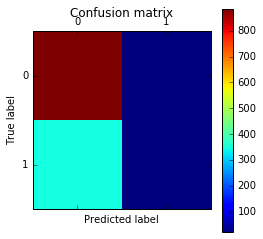

In [26]:
# Plot the confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

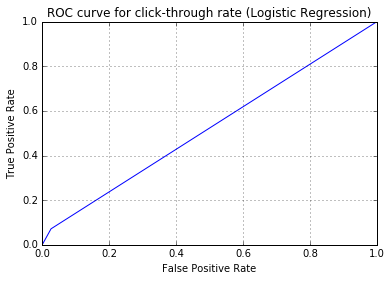

In [27]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for click-through rate (Logistic Regression)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [28]:
# Print out AUC, the percentage of the ROC plot that is underneath the curve
print('AUC using Logistic Regression = {:.2f}'.format(roc_auc_score(y_test, y_pred)))

AUC using Logistic Regression = 0.52


In [29]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
# 10-fold cross-validation for Logistic Regression
lreg_avg_cross_val_score = cross_val_score(lreg, X, y, cv=10, scoring='roc_auc').mean()
print('Cross-validated AUC for Logistic Regression = {:.2f}'.format(lreg_avg_cross_val_score))

Cross-validated AUC for Logistic Regression = 0.69


## Check accuracy score results using a few other classification algorithms
### k-nearest neighbor

In [30]:
# k-nearest neighbor KNN Model
from sklearn.neighbors import KNeighborsClassifier
# K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('Accuracy score using k-nearest neighbor = {:.2f}'.format(accuracy_score(y_test,y_pred)))
print('AUC using k-nearest neighbor = {:.2f}'.format(roc_auc_score(y_test,y_pred)))

Accuracy score using k-nearest neighbor = 0.65
AUC using k-nearest neighbor = 0.52


In [31]:
#Cross Validation
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn_avg_cross_val_score = cross_val_score(knn, X, y, cv=10, scoring='roc_auc').mean()
print('Cross-validated AUC for KNN = {:.2f}'.format(knn_avg_cross_val_score))

Cross-validated AUC for KNN = 0.57


### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
print('Accuracy score using Naive Bayes = {:.2f}'.format(accuracy_score(y_test,y_pred)))
print('AUC using Naive Bayes = {:.2f}'.format(roc_auc_score(y_test,y_pred)))

Accuracy score using Naive Bayes = 0.48
AUC using Naive Bayes = 0.58


In [33]:
#Cross Validation
#gnb = GaussianNB()
gnb_avg_cross_val_score = cross_val_score(gnb, X, y, cv=10, scoring='roc_auc').mean()
print('Cross-validated AUC for GaussianNB = {:.2f}'.format(gnb_avg_cross_val_score))

Cross-validated AUC for GaussianNB = 0.66


## Hyperparamater Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [35]:
# create lists of the parameter values that should be searched
# The penalty parameter is used to specify the norm used in the penalization
penaltyList = ['l1', 'l2']
#The C parameter is the inverse of regularization strength, must be a positive float, smaller values specify stronger regularization
Crange = [float(i)/10 for i in (list(range(1,10,1)))]
#Created a range of positive, float C values to search

In [36]:
# create a parameter grid by mapping the parameter names to the values/list that should be searched
param_grid = dict(penalty = penaltyList, C = Crange)
print(param_grid)

{'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'penalty': ['l1', 'l2']}


In [37]:
# instantiate and fit the grid
grid = GridSearchCV(lreg, param_grid, cv=3, scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [38]:
# view the complete results
grid.cv_results_

{'mean_fit_time': array([ 0.25979257,  1.19166025,  0.41960859,  1.19364953,  0.38341538,
         1.07521621,  0.40502151,  1.05259418,  0.63826148,  1.04714807,
         0.42125821,  1.06251446,  0.69382151,  1.19032049,  0.74295576,
         1.01594377,  0.33738645,  1.13059251]),
 'mean_score_time': array([ 0.0223008 ,  0.02619743,  0.01443521,  0.00736364,  0.00807428,
         0.00576576,  0.00844685,  0.0082794 ,  0.0051415 ,  0.00582997,
         0.01113939,  0.01236765,  0.00564011,  0.00698511,  0.00684786,
         0.00324202,  0.00829411,  0.01673317]),
 'mean_test_score': array([ 0.68777587,  0.68596436,  0.68762077,  0.68525695,  0.68760441,
         0.68573473,  0.68760948,  0.68586292,  0.68758552,  0.68640434,
         0.68755443,  0.68648134,  0.68754359,  0.68589619,  0.68753211,
         0.68506874,  0.68759836,  0.68676277]),
 'mean_train_score': array([ 0.69805071,  0.69671395,  0.69803324,  0.69633382,  0.69799309,
         0.69624885,  0.69796512,  0.69642044,  

In [39]:
# examine the best model
print('Best AUC for Logistic Regression = {:.2f}'.format(grid.best_score_))
print('')
print('Parameters for Best AUC for Logistic Regression = {}'.format(grid.best_params_))
print('')
print('Full list of paramemters for best estimator for Logistic Regression:\n {}'.format(grid.best_estimator_))

Best AUC for Logistic Regression = 0.69

Parameters for Best AUC for Logistic Regression = {'C': 0.1, 'penalty': 'l1'}

Full list of paramemters for best estimator for Logistic Regression:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### k-nearest neighbor

In [40]:
# create list of KNN (the n_neighbors parameter) values to search
KNNrange = [knn for knn in range(10,51,10)]
KNNrange.insert(0, 1)
#Created a range of integer KNN values between 1 and 50 in increments of 10
KNNrange

[1, 10, 20, 30, 40, 50]

In [41]:
# create a parameter grid by mapping the parameter names to the values/list that should be searched
param_grid = dict(n_neighbors = KNNrange)
print(param_grid)

{'n_neighbors': [1, 10, 20, 30, 40, 50]}


In [42]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=3, scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

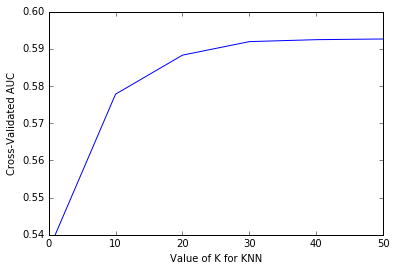

In [43]:
# plot the results
plt.plot(KNNrange, [j for j in grid.cv_results_['mean_test_score']])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated AUC')

In [44]:
# examine the best model
print('Best AUC for k-nearest neighbor = {:.2f}'.format(grid.best_score_))
print('')
print('Parameters for Best AUC for k-nearest neighbor = {}'.format(grid.best_params_))
print('')
print('Full list of paramemters for best estimator for k-nearest neighbor:\n {}'.format(grid.best_estimator_))

Best AUC for k-nearest neighbor = 0.59

Parameters for Best AUC for k-nearest neighbor = {'n_neighbors': 50}

Full list of paramemters for best estimator for k-nearest neighbor:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')


## Using spark-sklearn

In [45]:
!pip install pixiedust
import pixiedust
pixiedust.installPackage("databricks:spark-sklearn:0.2.0")

Pixiedust database opened successfully
Pixiedust version 0.73


/gpfs/fs01/user/seda-14cf7a76f410ab-a5f39cf201a0/.local/lib/python3.5/site-packages/pixiedust/display/chart/__init__.py:31: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  myLogger.warn("Unable to import renderer {0}: {1}".format(renderer, str(e)))


Package already installed: databricks:spark-sklearn:0.2.0


In [46]:
import numpy as np
from time import time

### Repeat Grid Search for KNN using scikit-learn  and timing the calculation

In [47]:
# import scikit learn GridSearchCV in case imported GridSearchCV from spark_sklearn
from sklearn.model_selection import GridSearchCV

In [48]:
# create a list of knn values to search
KNNrange = [knn for knn in range(10,51,20)]
print(KNNrange)
# create list of leaf_size values to search
leafDefault = 30
leafRange = [int(leafDefault/2), leafDefault, leafDefault*2]
print(leafRange)

[10, 30, 50]
[15, 30, 60]


In [49]:
# create a parameter grid by mapping the parameter names to the values/list that should be searched
param_grid = dict(n_neighbors = KNNrange, leaf_size=leafRange)
print(param_grid)

{'leaf_size': [15, 30, 60], 'n_neighbors': [10, 30, 50]}


In [50]:
# Calculate total number of combinations in the Grid Search
def multiply(elements):  
    product = 1
    for p in elements:
        product *= p  
    return product  
numParam = multiply([len(param_grid[x]) for x in param_grid])
print('Total number of combinations = {}'.format(numParam))

Total number of combinations = 9


In [51]:
# set the number of folds
numFolds = 5
grid = GridSearchCV(knn, param_grid, cv=numFolds, scoring='roc_auc')
start = time()
grid.fit(X, y)
scikitTime = time() - start
print("GridSearchCV took {:.2f} seconds for {:d} parameter combinations x {:d} folds.".format(scikitTime, numParam, numFolds))
print('')
print('Best AUC using scikit-learn = {:.2f}.'.format(grid.best_score_))

GridSearchCV took 283.84 seconds for 9 parameter combinations x 5 folds.

Best AUC using scikit-learn = 0.60.


### Using Spark this time and timing the calculation

In [53]:
# Use spark-sklearn
from spark_sklearn import GridSearchCV
grid = GridSearchCV(sc, knn, param_grid, cv=numFolds, scoring='roc_auc')
start = time()
grid.fit(X, y)
sparkTime = time() - start
print("GridSearchCV using spark-sklearn took {:.2f} seconds for {:d} parameter combinations x {:d} folds.".format(sparkTime, numParam, numFolds))
print('')
print('Best AUC using spark-sklearn = {:.2f}.'.format(grid.best_score_))

GridSearchCV using spark-sklearn took 14.85 seconds for 9 parameter combinations x 5 folds.

Best AUC using spark-sklearn = 0.60.


### Calculate Speedup by using spark-sklearn

In [54]:
print('Speedup = {:.2f}'.format((scikitTime/sparkTime)))

Speedup = 19.11
